Copyright 2023-2023 Lawrence Livermore National Security, LLC and other MuyGPyS
Project Developers. See the top-level COPYRIGHT file for details.

SPDX-License-Identifier: MIT

# Nonstationary tutorial

This notebook demonstrates how to use hierarchical nonstationary hyperparameters to perform nonstationary regression using a hierarchical model.

⚠️ _Note that this is still an experimental feature at this point._ ⚠️

We will set a random seed here for consistency when building docs.
In practice we would not fix a seed.

In [1]:
import numpy as np
np.random.seed(0)

## Preliminary setup

For simplicity, we start with an isotropic distortion so we only need to use a single `HierarchicalNonstationaryHyperparameter`. Let's also build a GP with a fixed length scale for comparison.

In [2]:
from MuyGPyS.gp import MuyGPS
from MuyGPyS.gp.distortion import IsotropicDistortion, l2
from MuyGPyS.gp.hyperparameter import ScalarHyperparameter
from MuyGPyS.gp.hyperparameter.experimental import (
    sample_knots,
    HierarchicalNonstationaryHyperparameter,
)
from MuyGPyS.gp.kernels import RBF

muygps_fixed = MuyGPS(
    kernel=RBF(
        metric=IsotropicDistortion(
            l2,
            length_scale=ScalarHyperparameter(1.0),
        ),
    ),
)

knot_count = 6
knot_features = sample_knots(feature_count=1, knot_count=knot_count)
knot_values = np.random.uniform(size=knot_count)
high_level_kernel = RBF()

muygps = MuyGPS(
    kernel=RBF(
        metric=IsotropicDistortion(
            l2,
            length_scale=HierarchicalNonstationaryHyperparameter(
                knot_features, knot_values, high_level_kernel
            ),
        ),
    ),
)

Let's create some training data with a little bit of noise.

In [3]:
x = np.linspace(-5, 5, num=50)
y = np.sinc(x) - np.mean(np.sinc(x))
train_features = np.reshape(x + np.random.normal(scale=0.02, size=50), (-1, 1))
train_responses = np.reshape(y + np.random.normal(scale=0.02, size=50), (-1, 1))

We can visualize what that looks like.

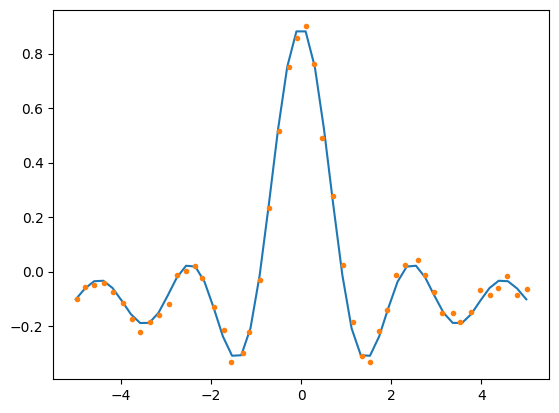

In [4]:
import matplotlib.pyplot as plt

plt.plot(x, y)
plt.plot(train_features, train_responses, '.')

We're going to try to predict random points of that function so let's create test features.

In [5]:
test_features = np.sort(
    np.concatenate(([-5, 5], np.random.uniform(-5, 5, size=18)))
).reshape((-1, 1))

Now we can proceed as usual to generate the nearest neighbors lookup index and tensors.

In [6]:
from MuyGPyS.neighbors import NN_Wrapper

nn_count = 30
nbrs_lookup = NN_Wrapper(train_features, nn_count, nn_method="exact", algorithm="ball_tree")

Note that in this simple example we're using all of the data as batch points, i.e. we're not really batching, since the dataset is very small.

In [7]:
from MuyGPyS.gp.tensors import make_predict_tensors

test_count, _ = test_features.shape
indices = np.arange(test_count)
test_nn_indices, _ = nbrs_lookup.get_nns(test_features)

(
    test_crosswise_diffs,
    test_pairwise_diffs,
    test_nn_targets,
) = make_predict_tensors(
    indices,
    test_nn_indices,
    test_features,
    train_features,
    train_responses,
)

Normally, at this point, we would optimize hyperparameters, but that part hasn't been implemented yet so we'll skip it for now.

One notable difference when using a hierarchical model is that the kernel takes an additional tensor, the batch tensor, which can be easily obtained using the `batch_features_tensor` helper function.

In [8]:
from MuyGPyS.gp.tensors import batch_features_tensor

batch_features = batch_features_tensor(test_features, indices)

Finally, we're ready to realize the kernel tensors and use them to predict the response of the test data. First using the GP with a fixed length scale.

In [9]:
Kcross_fixed = muygps_fixed.kernel(test_crosswise_diffs, batch_features)
K_fixed = muygps_fixed.kernel(test_pairwise_diffs, batch_features)
test_responses_mean_fixed = muygps_fixed.posterior_mean(K_fixed, Kcross_fixed, test_nn_targets)
test_responses_var_fixed = muygps_fixed.posterior_variance(K_fixed, Kcross_fixed)

Then the hierarchical GP.

In [10]:
Kcross = muygps.kernel(test_crosswise_diffs, batch_features)
K = muygps.kernel(test_pairwise_diffs, batch_features)
test_responses_mean = muygps.posterior_mean(K, Kcross, test_nn_targets)
test_responses_var = muygps.posterior_variance(K, Kcross)

And we can visualize the results by plotting the predicted means as well as one predicted standard deviation.

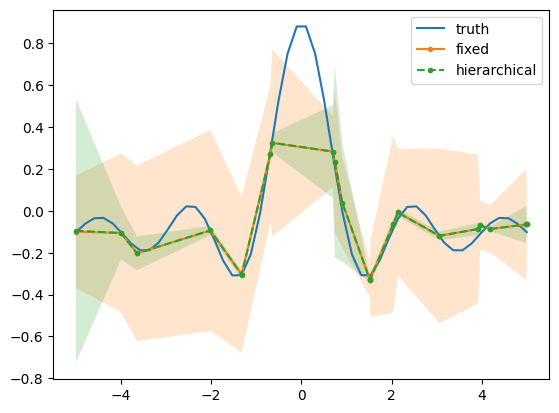

In [11]:
plt.plot(x, y, label="truth")
plt.plot(test_features, test_responses_mean_fixed, ".-", label="fixed")
plt.plot(test_features, test_responses_mean, ".--", label="hierarchical")
plt.fill_between(
    np.ravel(test_features),
    np.ravel(test_responses_mean_fixed + np.sqrt(test_responses_var_fixed) * 1.96),
    np.ravel(test_responses_mean_fixed - np.sqrt(test_responses_var_fixed) * 1.96),
    facecolor="C1",
    alpha=0.2,
)
plt.fill_between(
    np.ravel(test_features),
    np.ravel(test_responses_mean + np.sqrt(test_responses_var) * 1.96),
    np.ravel(test_responses_mean - np.sqrt(test_responses_var) * 1.96),
    facecolor="C2",
    alpha=0.2,
)
plt.legend()